In [1]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [2]:
device = torch.device('cpu:0')

In [3]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [3]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [91]:
# Load results of the fitting procedure

subject = 1
# fitting_type = 'gabor_OLS_36ori_12sf'
fitting_type = 'gabor_OLS_36ori_12sf_RANDOMVOXELDATA'
# fitting_type = 'gabor_ridge_36ori_12sf'
# fitting_type = 'gabor_ridge_8ori_3sf'
# fitting_type = 'gabor_combinations_ridge_8ori_3sf'

root = os.path.dirname(os.path.dirname(os.getcwd()))
folder2load = os.path.join(root, 'model_fits','S%02d'%subject, fitting_type)
# within this folder, assuming we want the most recent version that was saved
files_in_dir = os.listdir(folder2load)
from datetime import datetime
my_dates = files_in_dir
my_dates.sort(key=lambda date: datetime.strptime(date, "%b-%d-%Y_%H%M"))
most_recent_date = my_dates[-1]

subfolder2load = os.path.join(folder2load, most_recent_date)
file2load = os.listdir(subfolder2load)[0]
fullfile2load = os.path.join(subfolder2load, file2load)

print('loading from %s\n'%fullfile2load)

out = torch.load(fullfile2load)
print(out.keys())

loading from /user_data/mmhender/imStat/model_fits/S01/gabor_OLS_36ori_12sf_RANDOMVOXELDATA/Jun-15-2021_1641/all_fit_params

dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'covar_each_model_training', 'voxel_feature_correlations_val', 'zscore_features', 'nonlin_fn', 'padding_mode', 'debug'])


In [93]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']
models = out['models']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
val_r2 = out['val_r2']
best_params = out['best_params']
best_lambdas = out['best_lambdas']
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
covar_each_model_training = out['covar_each_model_training']
                                     
zscore_features = out['zscore_features']
print('zscore_features=%s\n'%zscore_features)
nonlin_fn = out['nonlin_fn']
padding_mode = out['padding_mode']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_model_inds = best_params[5]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

# also listing roi names here
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)

if 'combs_zstats' in out.keys():
    combs_zstats = out['combs_zstats']
else:
    combs_stats=None

zscore_features=False

(11694, 3)
(11694, 432)


In [40]:
feature_table

,cycles per stimulus,pix per stimulus,orientation,cycles per filter,pix per filter,gauss. env. radius (pix)
0,3.0,12,0.000000,2.8,12.0,2.891
1,3.0,12,0.087266,2.8,12.0,2.891
2,3.0,12,0.174533,2.8,12.0,2.891
3,3.0,12,0.261799,2.8,12.0,2.891
4,3.0,12,0.349066,2.8,12.0,2.891
...,...,...,...,...,...,...
427,72.0,297,2.705260,2.8,12.0,2.891
428,72.0,297,2.792527,2.8,12.0,2.891
429,72.0,297,2.879793,2.8,12.0,2.891
430,72.0,297,2.967060,2.8,12.0,2.891


Text(0.5, 0.98, 'S01, gabor_OLS_36ori_12sf_RANDOMVOXELDATA')

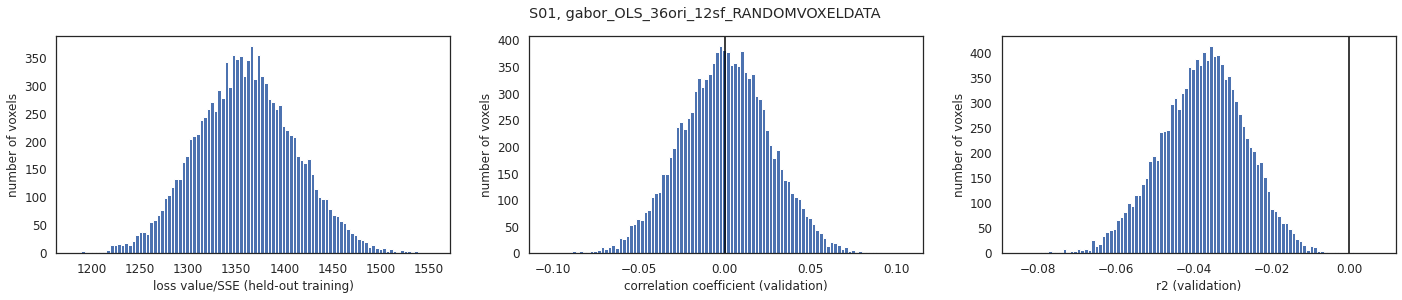

In [94]:
# Plot summary of performance

plt.figure(figsize=(24,4));

plt.subplot(1,3,1)
plt.hist(best_losses,100)
# plt.xlim([500,2000])
plt.xlabel('loss value/SSE (held-out training)');
plt.ylabel('number of voxels');

plt.subplot(1,3,2)
plt.hist(val_cc,100)
# plt.xlim([-0.2, 0.8])
plt.xlabel('correlation coefficient (validation)');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')

plt.subplot(1,3,3)
plt.hist(val_r2,100)
# plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(0,color='k')
# plt.xlim([-0.2, 0.8])
plt.ylabel('number of voxels')
plt.xlabel('r2 (validation)')

plt.suptitle('S%02d, %s'%(subject, fitting_type))

In [30]:
val_cc

array([-0.06301899, -0.0148504 ,  0.01649215, ...,  0.00372128,
        0.0227479 , -0.01175022], dtype=float32)

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 1.0, 'S01, gabor_OLS_36ori_12sf_SHUFFLEIMAGES')

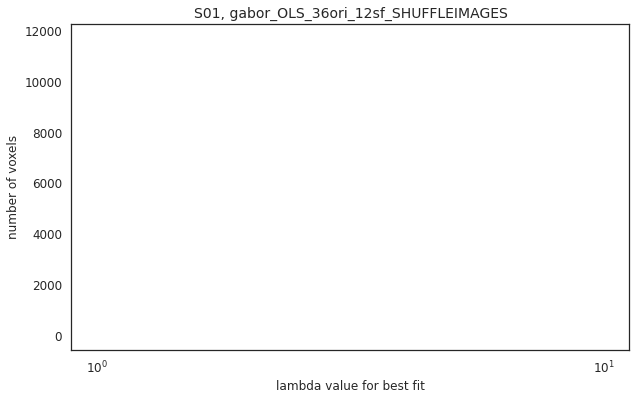

In [77]:
plt.figure(figsize=(10,6))
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');
plt.title('S%02d, %s'%(subject, fitting_type))

Text(0.5, 0.98, 'Correlation coef. on validation set\nS01, gabor_OLS_36ori_12sf_RANDOMVOXELDATA')

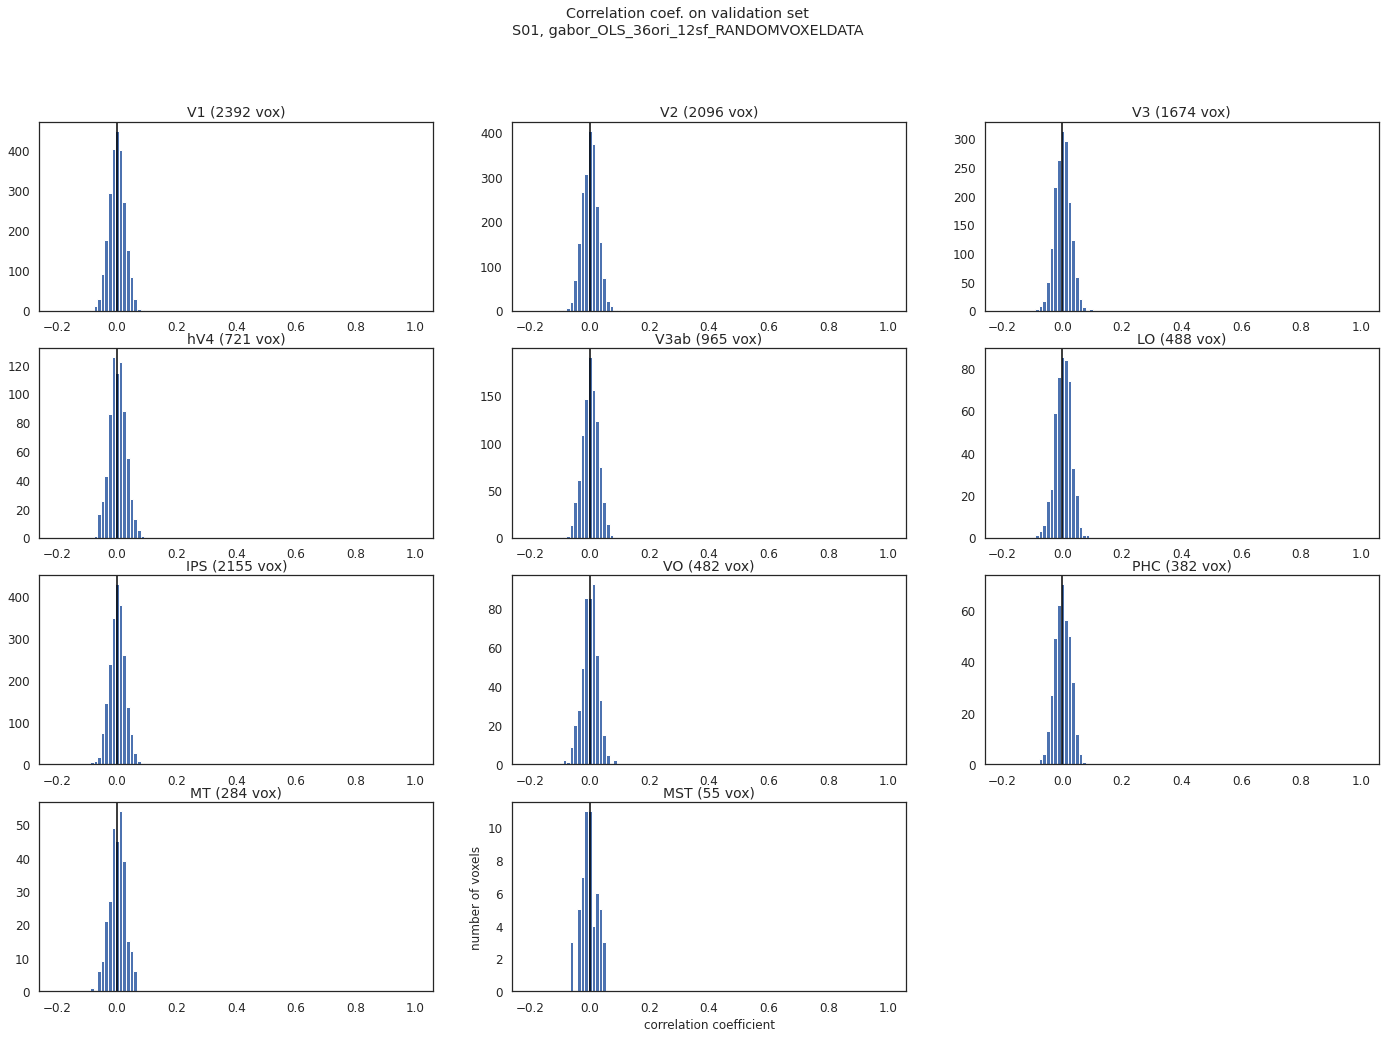

In [95]:
# Plot correlation coefficient for each ROI separately.

plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-2:
        plt.xlabel('correlation coefficient')
        plt.ylabel('number of voxels')
#     else:
#         plt.xticks([])
#         plt.yticks([])
        
    plt.axvline(0,color='k')
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set\nS%02d, %s'%(subject, fitting_type))

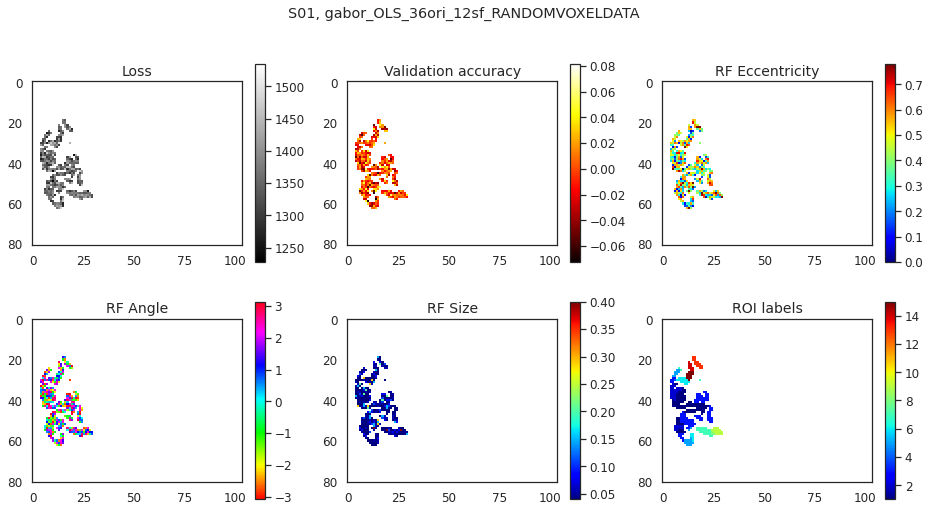

In [96]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

sys.path.append(os.path.join(root,'code'))
from utils import file_utility

volume_loss = file_utility.view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = file_utility.view_data(brain_nii_shape, voxel_idx, val_cc)
volume_ecc  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ecc)
volume_ang  = file_utility.view_data(brain_nii_shape, voxel_idx, best_ang)
volume_size = file_utility.view_data(brain_nii_shape, voxel_idx, best_size)
volume_roi = file_utility.view_data(brain_nii_shape, voxel_idx, voxel_roi)

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

plt.suptitle('S%02d, %s'%(subject, fitting_type));

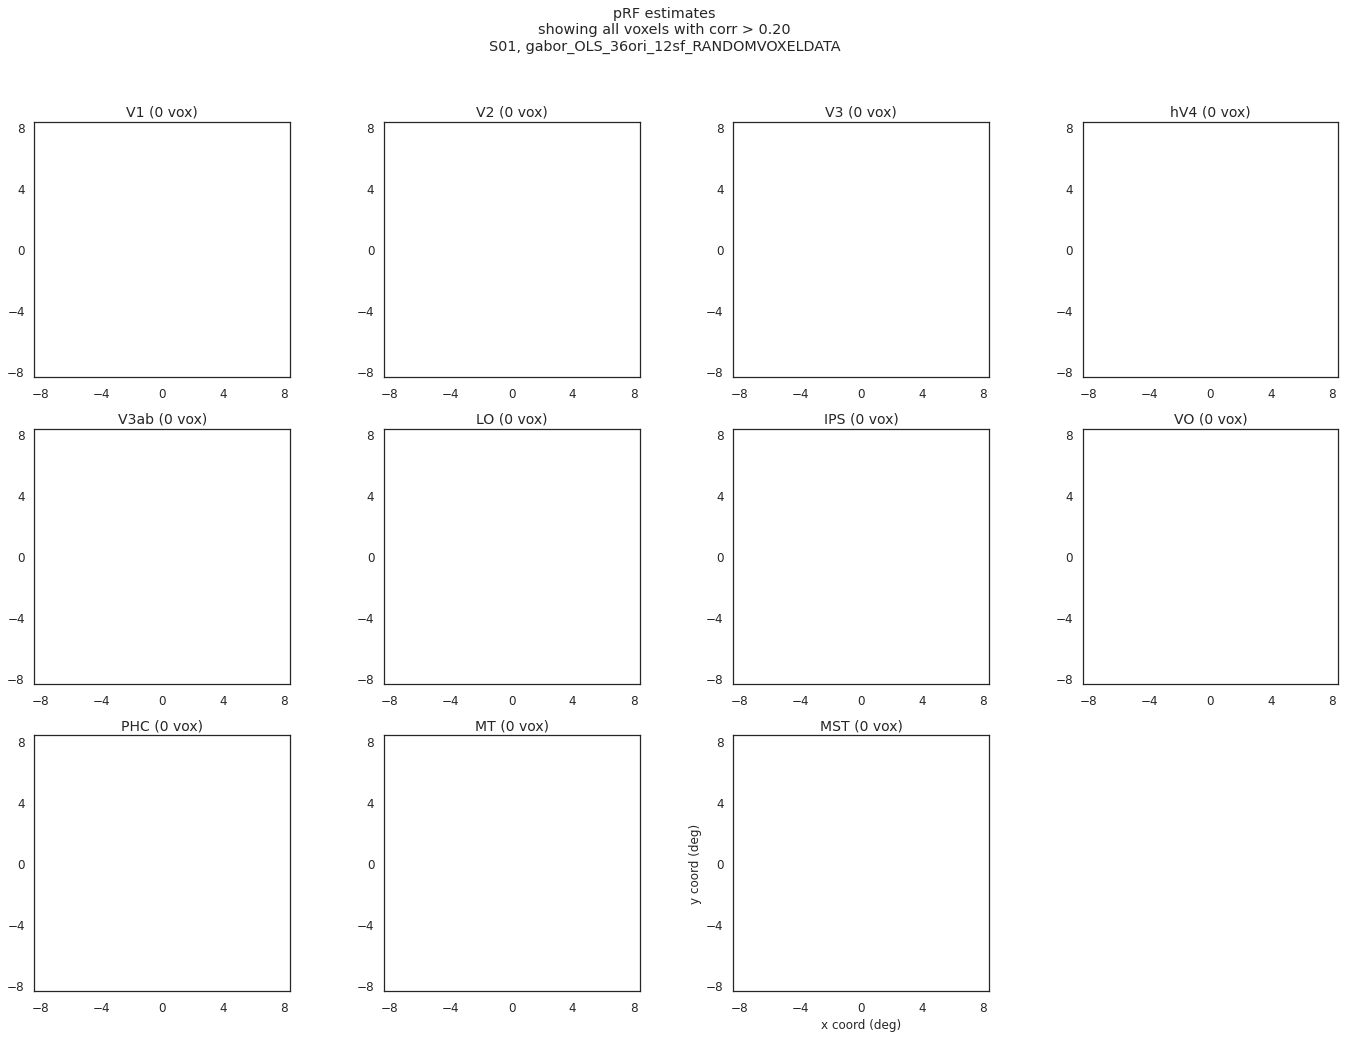

In [97]:
# Plot spatial RF estimates
import matplotlib

eccen_deg = 8.4
best_models_deg = best_models*eccen_deg

npy = int(np.ceil(np.sqrt(n_rois)))
npx = int(np.ceil(n_rois/npy))

plt.figure(figsize=(24,16))

cc_cutoff = 0.20

for rr in range(n_rois-1):
# for rr in range(1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.where(np.logical_and(inds_this_roi, abv_thresh))[0]
    
    plt.subplot(npx,npy,rr+1)
    ax = plt.gca()

    for vi, vidx in enumerate(inds2use):
       
        plt.plot(best_models_deg[vidx,0], best_models_deg[vidx,1],'.',color='k')
        circ = matplotlib.patches.Circle((best_models_deg[vidx,0], best_models_deg[vidx,1]), best_models_deg[vidx,2], color = [0.8, 0.8, 0.8], fill=False)
        ax.add_artist(circ)
   
    plt.axis('square')
    
    plt.xlim([-eccen_deg, eccen_deg])
    plt.ylim([-eccen_deg, eccen_deg])
    plt.xticks(np.arange(-8,9,4))
    plt.yticks(np.arange(-8,9,4))
    if rr==n_rois-2:
        plt.xlabel('x coord (deg)')
        plt.ylabel('y coord (deg)')
    plt.title('%s (%d vox)'%(group_names[rr], len(inds2use)))

plt.suptitle('pRF estimates\nshowing all voxels with corr > %.2f\nS%02d, %s'%(cc_cutoff, subject, fitting_type));


In [98]:
# Assessing spatial frequency and orientation tuning

allcorrs_reshaped = np.reshape(voxel_feature_correlations_val, [n_voxels, n_ori, n_sf], order='F')

mean_orient_corrs = np.mean(allcorrs_reshaped, axis=2)
print(np.shape(mean_orient_corrs))
mean_sf_corrs = np.mean(allcorrs_reshaped, axis=1)
print(np.shape(mean_sf_corrs))

max_orient_corr_ind = np.argmax(mean_orient_corrs, axis=1)
preferred_ori_corrs = orients_deg[max_orient_corr_ind]

max_sf_corr_ind = np.argmax(mean_sf_corrs, axis=1)
preferred_sf_corrs = cyc_per_stim[max_sf_corr_ind]

allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')

mean_orient_weights = np.mean(allw_reshaped, axis=2)
print(np.shape(mean_orient_weights))
mean_sf_weights = np.mean(allw_reshaped, axis=1)
print(np.shape(mean_sf_weights))

max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
preferred_ori_weights = orients_deg[max_orient_weight_ind]

max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
preferred_sf_weights = cyc_per_stim[max_sf_weight_ind]

# double check that the reshaping was done correctly
sf=0
oo=0
print(allw_reshaped[0,:,sf])
print(feature_weights[0,sf_tuning_masks[sf]])
print(allcorrs_reshaped[0,:,sf])
print(voxel_feature_correlations_val[0,sf_tuning_masks[sf]])

print(allw_reshaped[0,oo,:])
print(feature_weights[0,ori_tuning_masks[oo]])
print(allcorrs_reshaped[0,oo,:])
print(voxel_feature_correlations_val[0,ori_tuning_masks[oo]])


(11694, 36)
(11694, 12)
(11694, 36)
(11694, 12)
[-40.380608   20.947203   16.996853  -58.08349    80.133255  -75.10314
  28.844412   21.833202  -27.638998    0.9420029  -8.036262   53.840508
 -79.72978    66.689545  -38.202995   25.933788  -37.38869    53.499966
 -52.710815   40.08407   -22.290451    1.4112272  27.86822   -52.80681
  56.122242  -32.827835   17.140026  -30.632772   45.656406  -44.807606
  32.332207   -5.123601  -26.678415   56.575035  -70.15393    60.67729  ]
[-40.380608   20.947203   16.996853  -58.08349    80.133255  -75.10314
  28.844412   21.833202  -27.638998    0.9420029  -8.036262   53.840508
 -79.72978    66.689545  -38.202995   25.933788  -37.38869    53.499966
 -52.710815   40.08407   -22.290451    1.4112272  27.86822   -52.80681
  56.122242  -32.827835   17.140026  -30.632772   45.656406  -44.807606
  32.332207   -5.123601  -26.678415   56.575035  -70.15393    60.67729  ]
[-2.1043338e-02 -2.2098094e-02 -1.8104294e-02 -1.1798925e-02
 -1.0868916e-02 -1.2810358e

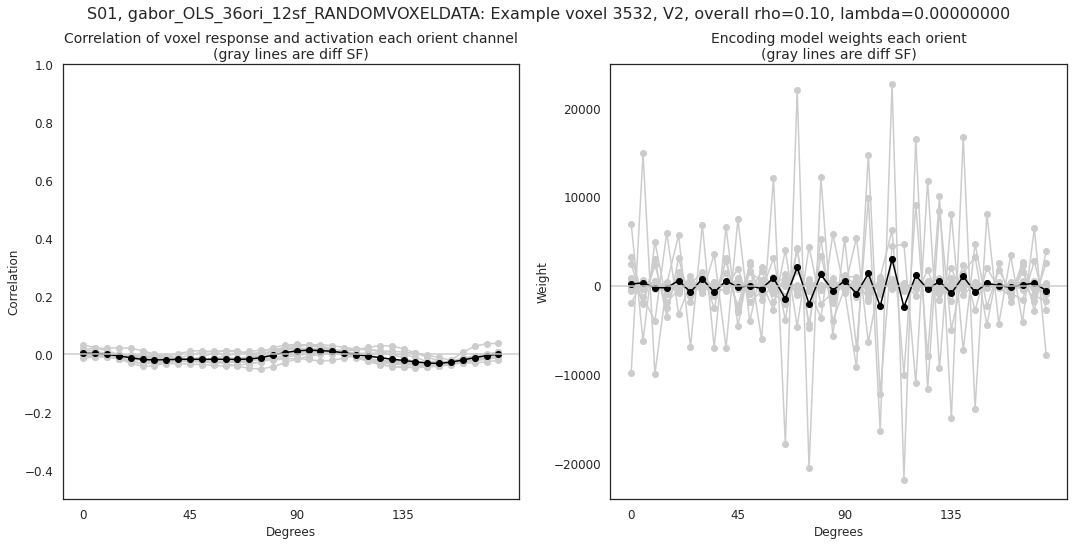

In [99]:
# Plotting orientation tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(orients_deg, allcorrs_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg,  mean_orient_corrs[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each orient channel\n(gray lines are diff SF)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
plt.ylim([-0.5,1])

plt.subplot(1,2,2)
plt.plot(orients_deg, allw_reshaped[vidx,:,:],'-o',color=[0.8, 0.8, 0.8])
plt.plot(orients_deg, mean_orient_weights[vidx,:],'-o',color='k')
plt.xlabel('Degrees')
plt.ylabel('Weight')
plt.title('Encoding model weights each orient\n(gray lines are diff SF)')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.xticks(np.arange(0,179,45))
# plt.ylim([-1,1])

roi_ind = np.where([np.isin(voxel_roi[vidx], group[ii]) for ii in range(len(group))])[0][0]
plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f, lambda=%.8f'%( subject, fitting_type, vidx, group_names[roi_ind], val_cc[vidx],lambdas[best_lambdas[vidx]]),fontsize=16);

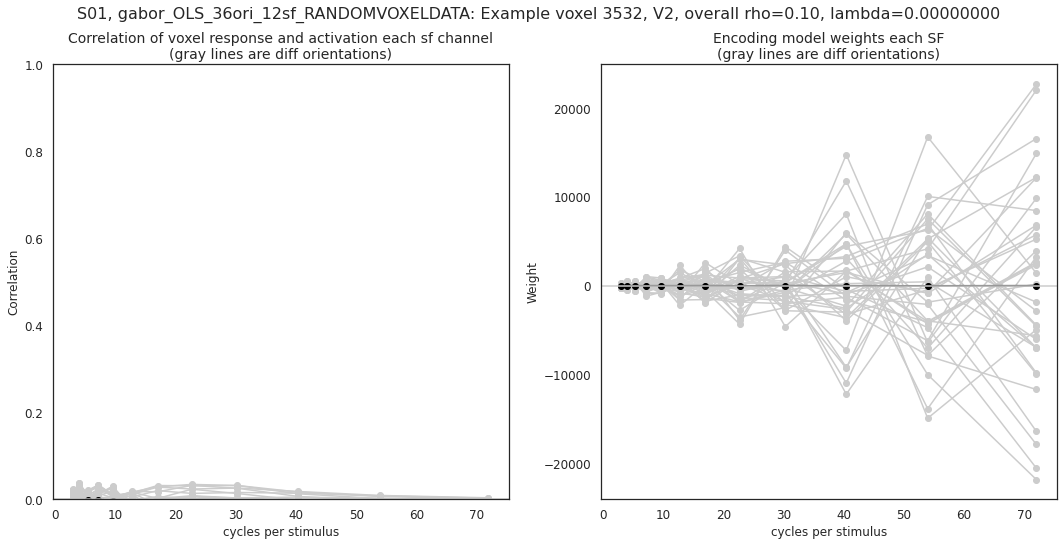

In [100]:
# Plotting SF tuning for one example voxel

vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(cyc_per_stim, np.transpose(allcorrs_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim, mean_sf_corrs[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and activation each sf channel\n(gray lines are diff orientations)')
# plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])
plt.ylim([0,1])

plt.subplot(1,2,2)
plt.plot(cyc_per_stim, np.transpose(allw_reshaped[vidx,:,:]),'-o',color=[0.8, 0.8, 0.8])
plt.plot(cyc_per_stim, mean_sf_weights[vidx,:],'-o',color='k')
plt.xlabel('cycles per stimulus')
plt.ylabel('Weight')
plt.title('Encoding model weights each SF\n(gray lines are diff orientations)')
plt.axhline(0, color=[0.8, 0.8, 0.8])

roi_ind = np.where([np.isin(voxel_roi[vidx], group[ii]) for ii in range(len(group))])[0][0]
plt.suptitle('S%02d, %s: Example voxel %d, %s, overall rho=%.2f, lambda=%.8f'%( subject, fitting_type, vidx, group_names[roi_ind], val_cc[vidx],lambdas[best_lambdas[vidx]]),fontsize=16);

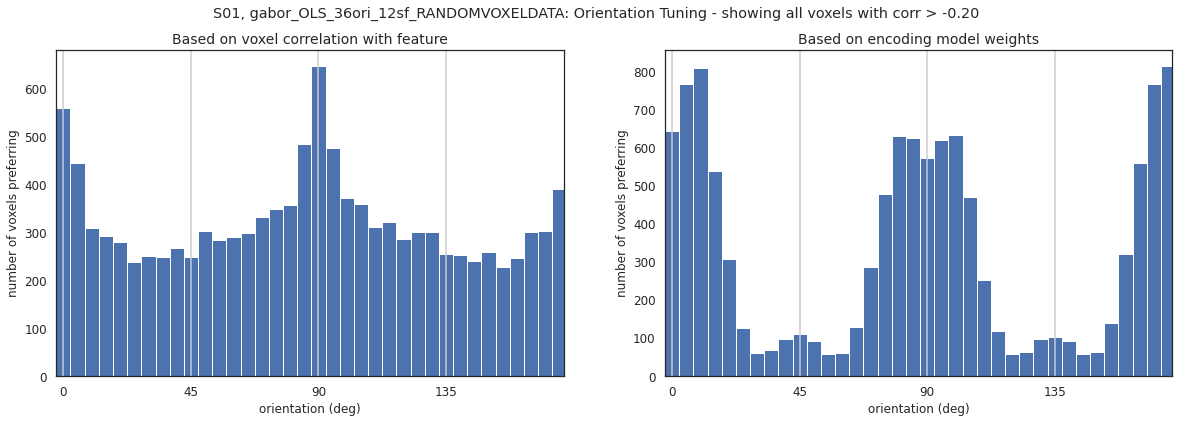

In [101]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(20,6))

cc_cutoff = -0.2
abv_thresh = val_cc>cc_cutoff

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_ori_corrs[abv_thresh],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
unvals, counts = np.unique(preferred_ori_corrs[abv_thresh], return_counts=True)

plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')
for ii in np.arange(0,181,45):
    plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_ori_weights[abv_thresh],1), bins=np.arange(0,180+180/n_ori,180/n_ori) );
unvals, counts = np.unique(preferred_ori_weights[abv_thresh], return_counts=True)

plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
plt.xlim([0,179])
plt.xlabel('orientation (deg)')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')
for ii in np.arange(0,181,45):
    plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
plt.suptitle('S%02d, %s: Orientation Tuning - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

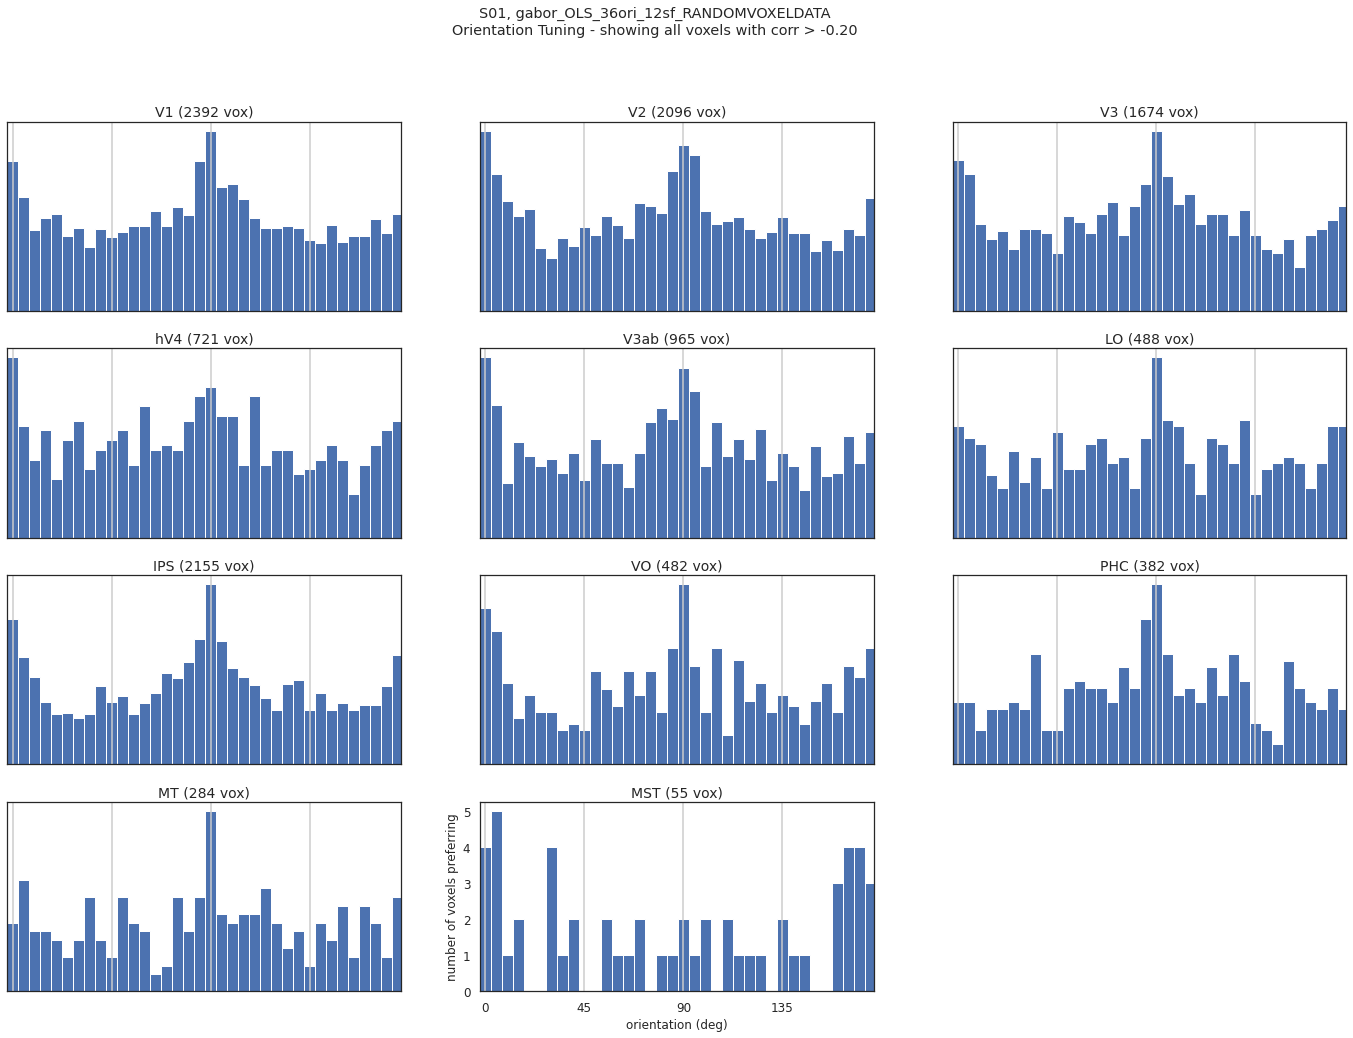

In [102]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

cc_cutoff = -0.2

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_ori_corrs[inds2use],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
    unvals, counts = np.unique(preferred_ori_corrs[inds2use], return_counts=True)

    plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
    plt.xlim([0,179])
    if rr==n_rois-2:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])
        
    for ii in np.arange(0,181,45):
        plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('S%02d, %s\nOrientation Tuning - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

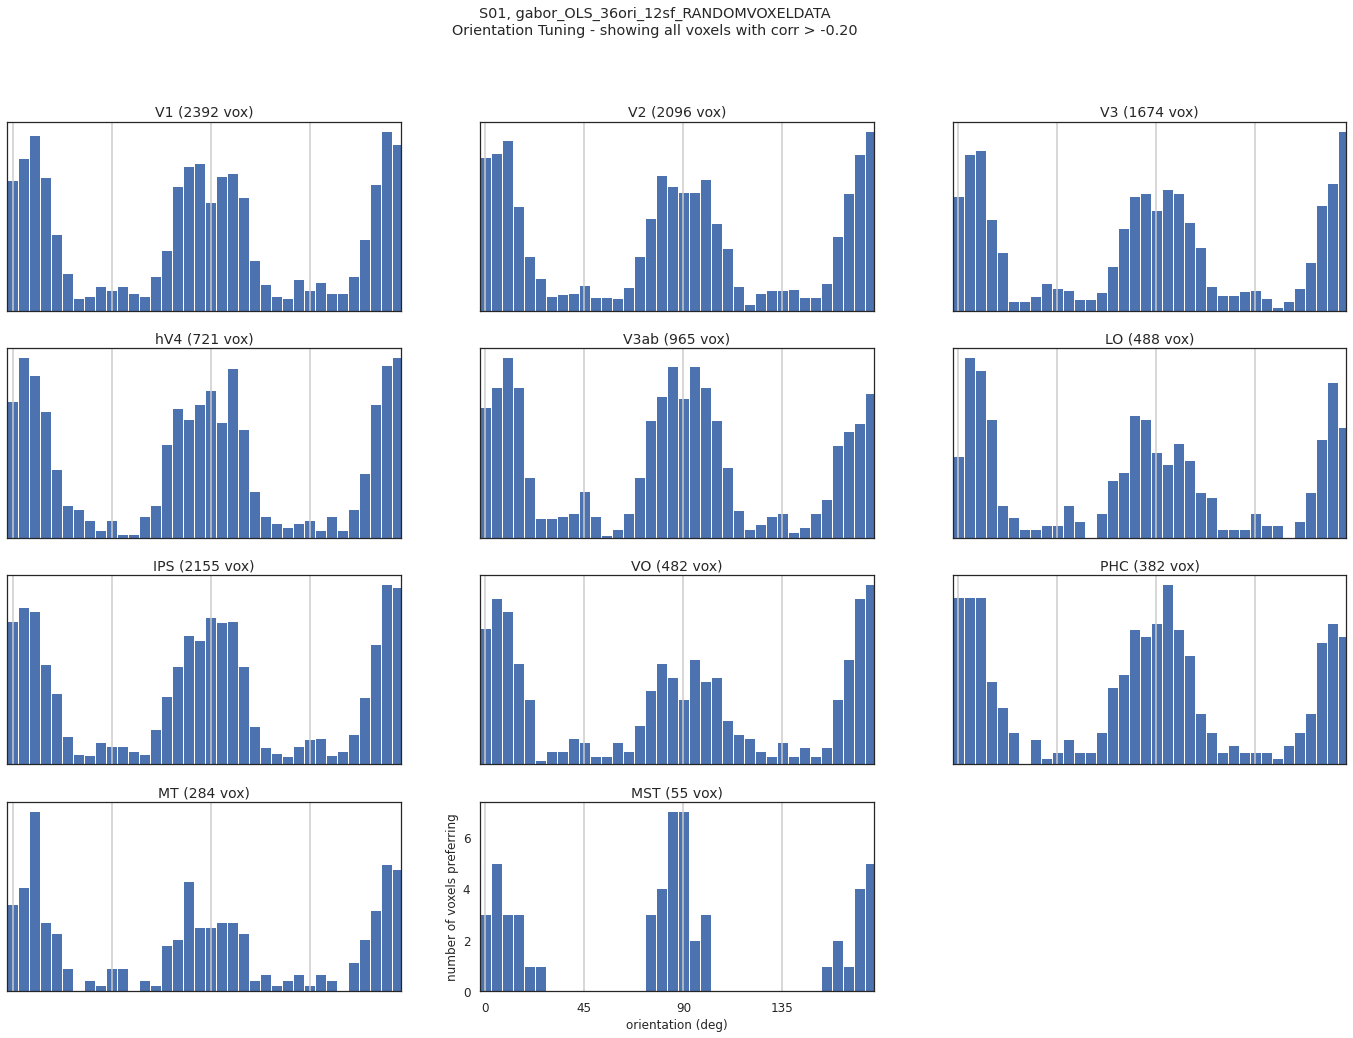

In [103]:
# Plot histogram of the orientation "tuning preferences" based on weights
plt.figure(figsize=(24,16))
npx = int(np.ceil(np.sqrt(n_rois)))
npy = int(np.ceil(n_rois/npx))

cc_cutoff = -0.2

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_ori_weights[inds2use],0), bins=np.arange(0,180+180/n_ori,180/n_ori) );
    unvals, counts = np.unique(preferred_ori_weights[inds2use], return_counts=True)

    plt.xticks(np.arange(0,179,45)+180/n_ori/2, np.arange(0,179,45))
    plt.xlim([0,179])
    if rr==n_rois-2:
        plt.xlabel('orientation (deg)')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])
        
    for ii in np.arange(0,181,45):
        plt.axvline(ii+180/n_ori/2,color=[0.8, 0.8, 0.8])
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('S%02d, %s\nOrientation Tuning - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

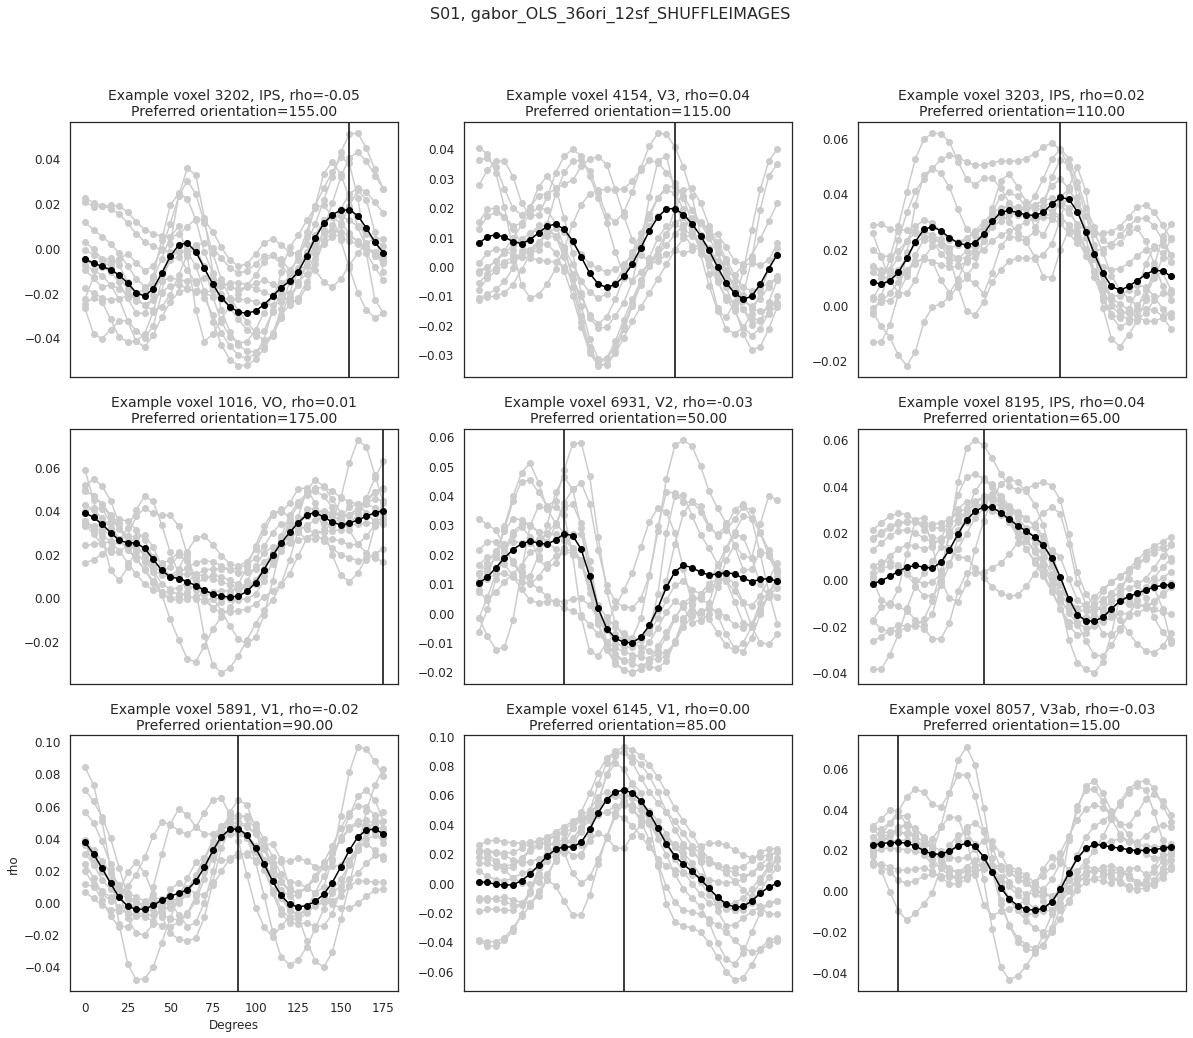

In [86]:
# Plotting orient tuning for several example voxels (based on correlation of resp with orientation channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

# vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, allcorrs_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_ori_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f\nPreferred orientation=%.2f'%(vv, group_names[roi_ind], val_cc[vv],  preferred_ori_corrs[vv]))
    
plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);

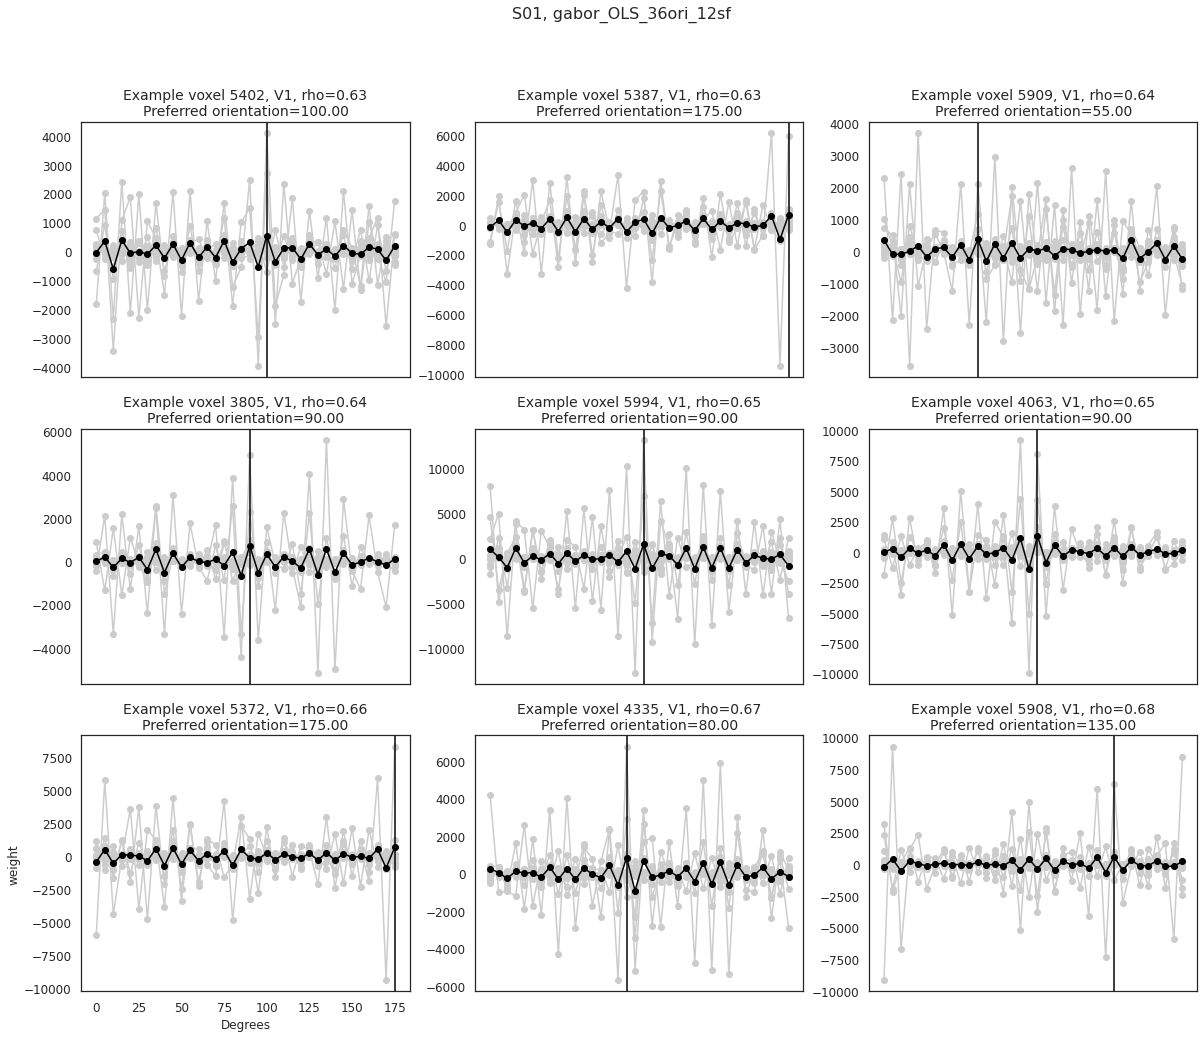

In [22]:
# Plotting orientation tuning for several example voxels (based on encoding model wts)
n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(orients_deg, allw_reshaped[vv,:,:],'-o',color=[0.8, 0.8, 0.8])
    plt.plot(orients_deg, mean_orient_weights[vv,:],'-o',color='k')  
    plt.axvline(preferred_ori_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('Degrees')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f\nPreferred orientation=%.2f'%(vv, group_names[roi_ind], val_cc[vv],  preferred_ori_weights[vv]))
    
plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);

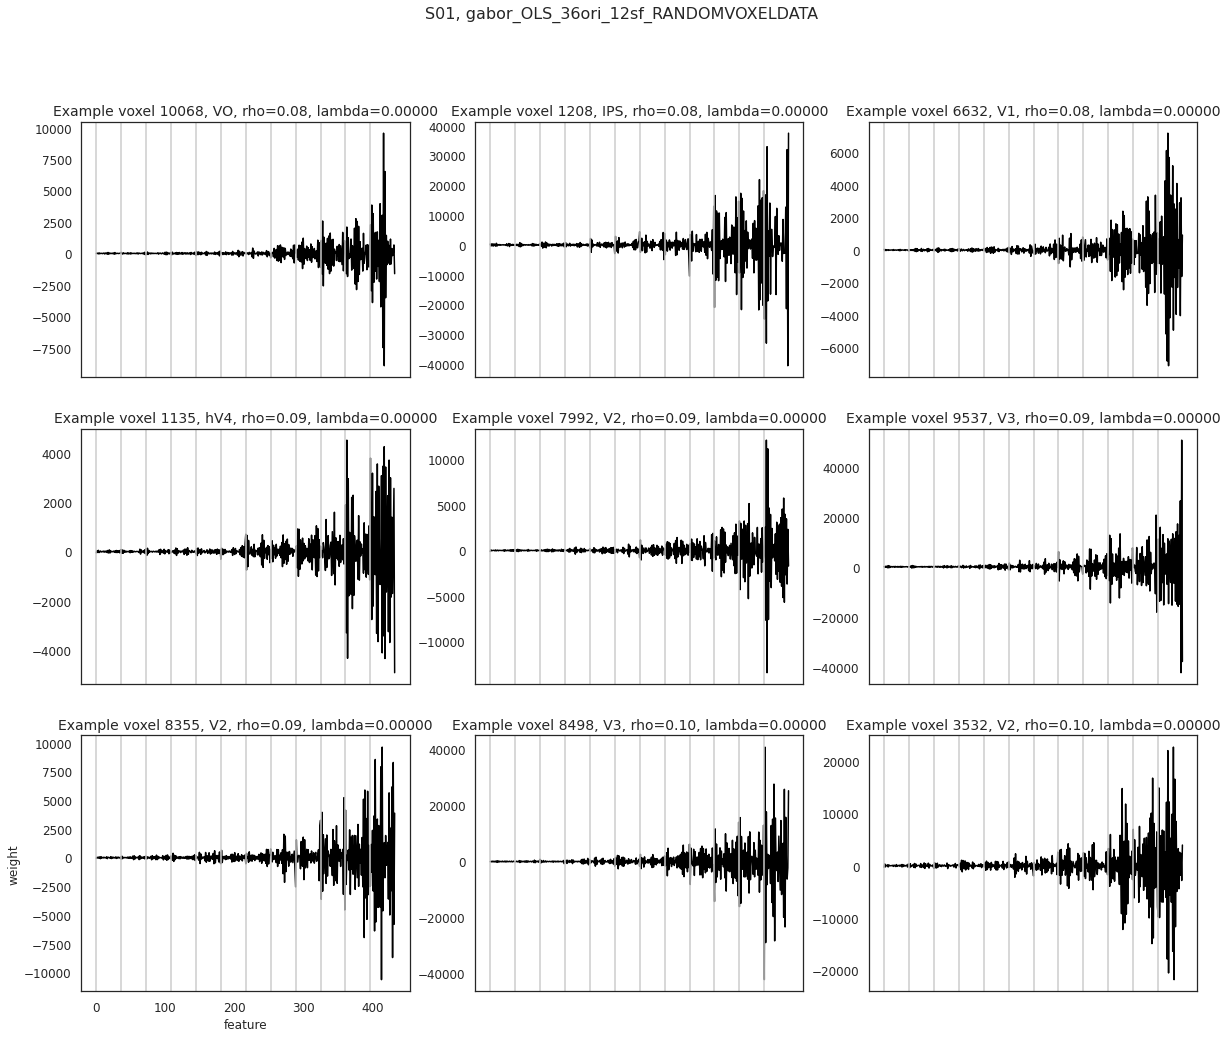

In [104]:
# Plotting weights for all features, several example voxels

n2plot = 9
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    weights = feature_weights[vv,:]
    plt.plot(weights,color='k')
    for ii in np.arange(0,n_sf*n_ori, n_ori):
#     for ii in np.arange(0,n_features_total, n_ori*n_sf):
        plt.axvline(ii,color=[0.8, 0.8, 0.8])
   
    if vi==(npx-1)*npy:
        plt.xlabel('feature')
        plt.ylabel('weight')
    else:
        plt.xticks([]); 
#         plt.yticks([])

    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f, lambda=%.5f'%(vv,group_names[roi_ind], val_cc[vv],lambdas[best_lambdas[vv]]))

plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);

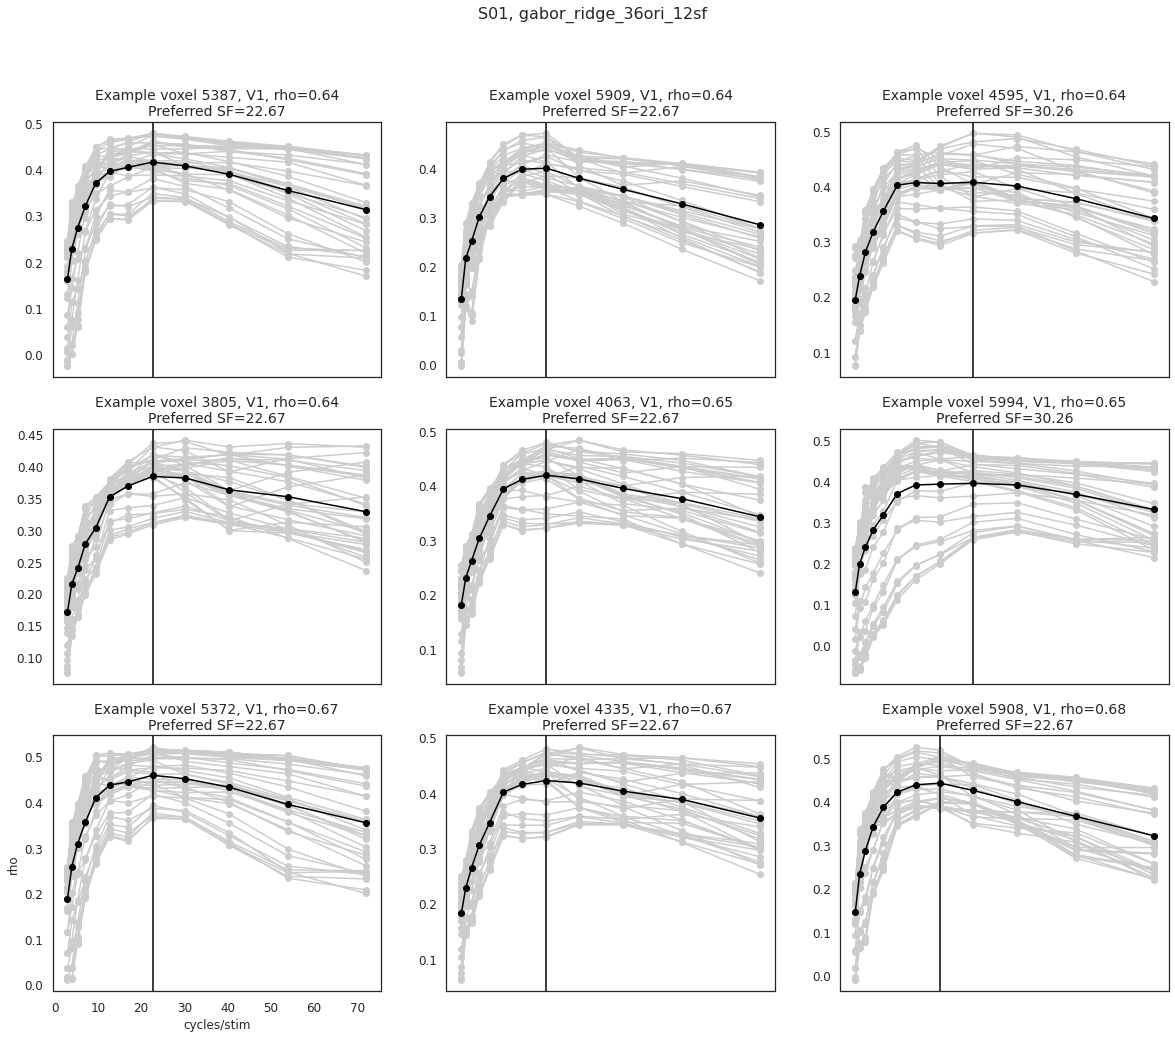

In [57]:
# Plotting SF tuning for several example voxels (based on correlation of resp with SF channel activation)
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim, np.transpose(allcorrs_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim, mean_sf_corrs[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_corrs[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f\nPreferred SF=%.2f'%(vv, group_names[roi_ind], val_cc[vv], preferred_sf_corrs[vv]))

plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);

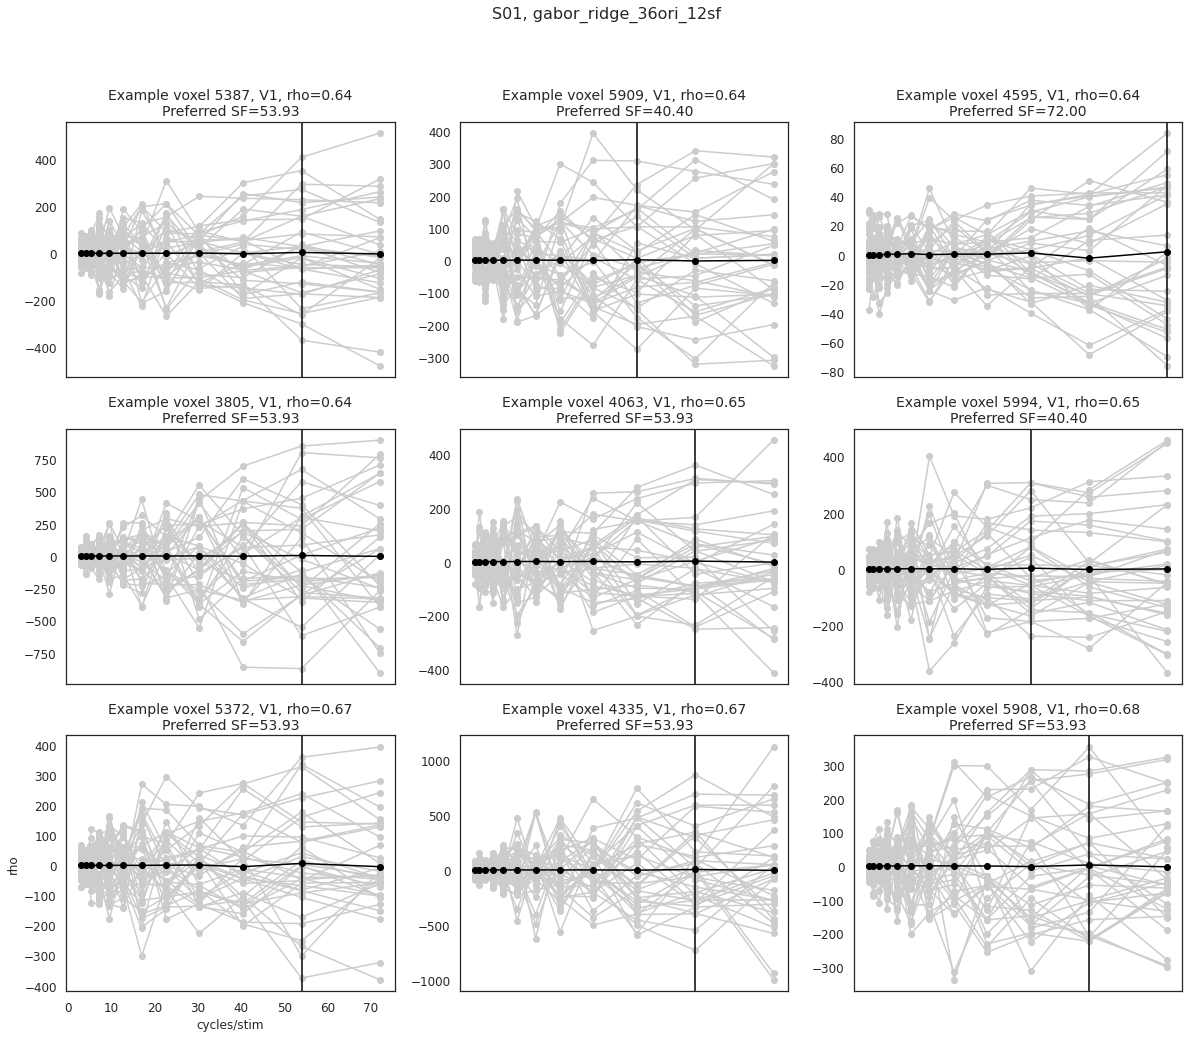

In [58]:
# Plotting SF tuning for several example voxels (based on encoding model wts);
n2plot = 9 
npx = int(np.ceil(np.sqrt(n2plot)))
npy = int(np.ceil(n2plot/npx))

vox2plot = np.argsort(np.nan_to_num(val_cc))[-n2plot:] # choosing vox w best validation set performance
# vox2plot = np.random.randint(0,len(val_cc),n2plot)

plt.figure(figsize=(20,16))
for vi, vv in enumerate(vox2plot):

    plt.subplot(npx, npy, vi+1)   
    plt.plot(cyc_per_stim, np.transpose(allw_reshaped[vv,:,:]),'-o',color=[0.8, 0.8, 0.8])
    plt.plot(cyc_per_stim, mean_sf_weights[vv,:],'-o',color='k')
#     plt.plot(orients_deg, mean_orient_corrs[vv,:], '-o')    
    plt.axvline(preferred_sf_weights[vv],color='k')
    if vi==(npx-1)*npy:
        plt.xlabel('cycles/stim')
        plt.ylabel('rho')
    else:
        plt.xticks([]); 
#         plt.yticks([])
    roi_ind = np.where([np.isin(voxel_roi[vv], group[ii]) for ii in range(len(group))])[0][0]
    plt.title('Example voxel %d, %s, rho=%.2f\nPreferred SF=%.2f'%(vv, group_names[roi_ind], val_cc[vv], preferred_sf_weights[vv]))

plt.suptitle('S%02d, %s'%( subject, fitting_type),fontsize=16);    

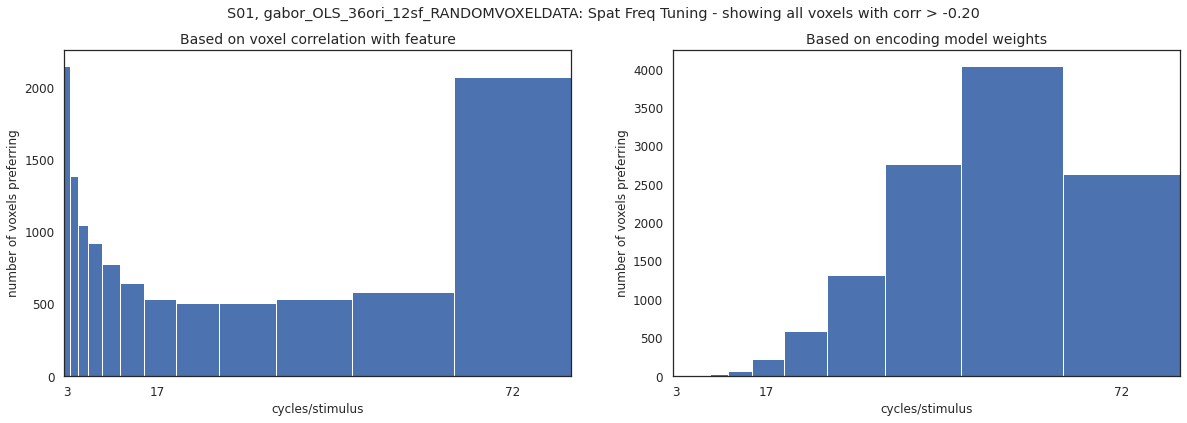

In [105]:
# Plot histogram of the "tuning preferences" based on correlation coefficient

cc_cutoff = -0.2
abv_thresh = val_cc>cc_cutoff


better_bin_edges = [cyc_per_stim[ii] - np.diff(cyc_per_stim[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim))]
better_bin_edges.insert(0, cyc_per_stim[0] - np.diff(cyc_per_stim[0:2])/2)
better_bin_edges.append(cyc_per_stim[-1] + np.diff(cyc_per_stim[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
h = plt.hist(np.round(preferred_sf_corrs[abv_thresh],0), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_corrs[abv_thresh], return_counts=True)

plt.xticks(np.round(cyc_per_stim[[0,int(n_sf/2),-1]]))
# plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on voxel correlation with feature')

plt.subplot(1,2,2)
h = plt.hist(np.round(preferred_sf_weights[abv_thresh],1), bins=better_bin_edges );
unvals, counts = np.unique(preferred_sf_weights[abv_thresh], return_counts=True)

plt.xticks(np.round(cyc_per_stim[[0,int(n_sf/2),-1]]))
# plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
plt.xlabel('cycles/stimulus')
plt.ylabel('number of voxels preferring')
plt.title('Based on encoding model weights')

plt.suptitle('S%02d, %s: Spat Freq Tuning - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


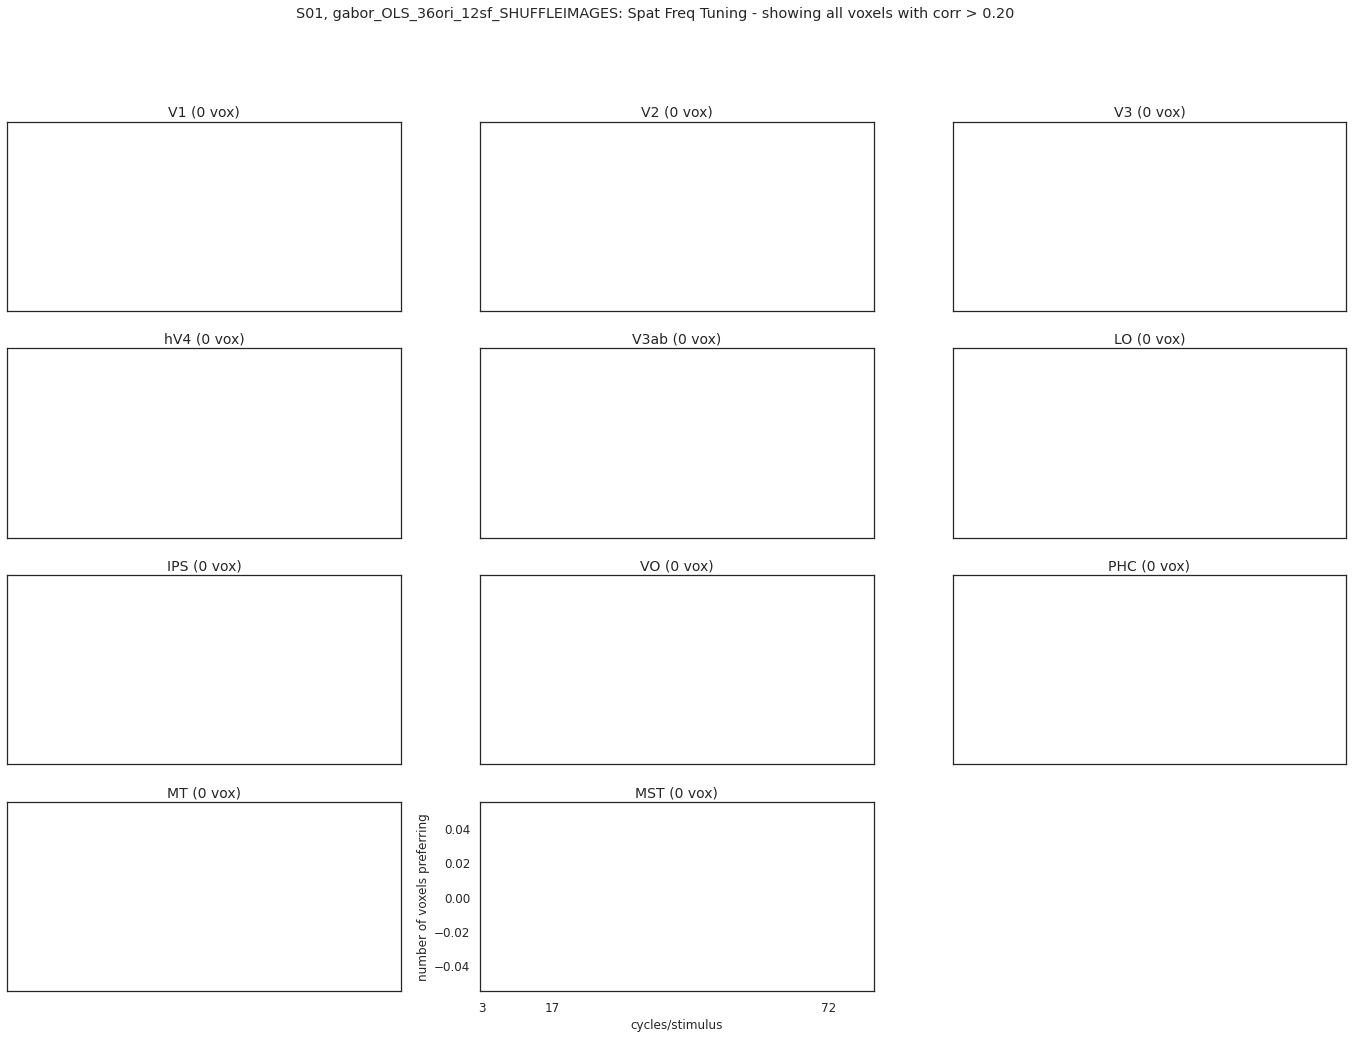

In [89]:
# Plot histogram of the sf "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

better_bin_edges = [cyc_per_stim[ii] - np.diff(cyc_per_stim[ii-1:ii+1])/2 for ii in np.arange(1,len(cyc_per_stim))]
better_bin_edges.insert(0, cyc_per_stim[0] - np.diff(cyc_per_stim[0:2])/2)
better_bin_edges.append(cyc_per_stim[-1] + np.diff(cyc_per_stim[-2:])/2)
better_bin_edges = np.squeeze(better_bin_edges)


cc_cutoff = 0.2

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(np.round(preferred_sf_corrs[inds2use],0), bins=better_bin_edges);
    
    plt.xticks(np.round(cyc_per_stim[[0,int(n_sf/2),-1]]))
#     plt.xticks(np.round(cyc_per_stim[[0,4]+list(np.arange(6,n_sf))],1))
    plt.xlim([np.min(better_bin_edges), np.max(better_bin_edges)])
    
    if rr==n_rois-2:
        plt.xlabel('cycles/stimulus')
        plt.ylabel('number of voxels preferring')
    else:
        plt.xticks([])
        plt.yticks([])

    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('S%02d, %s: Spat Freq Tuning - showing all voxels with corr > %.2f'%(subject, fitting_type, cc_cutoff));

Text(0.5, 1.0, 'mean of each feature in validation set images\ngabor_OLS_36ori_12sf_RANDOMVOXELDATA')

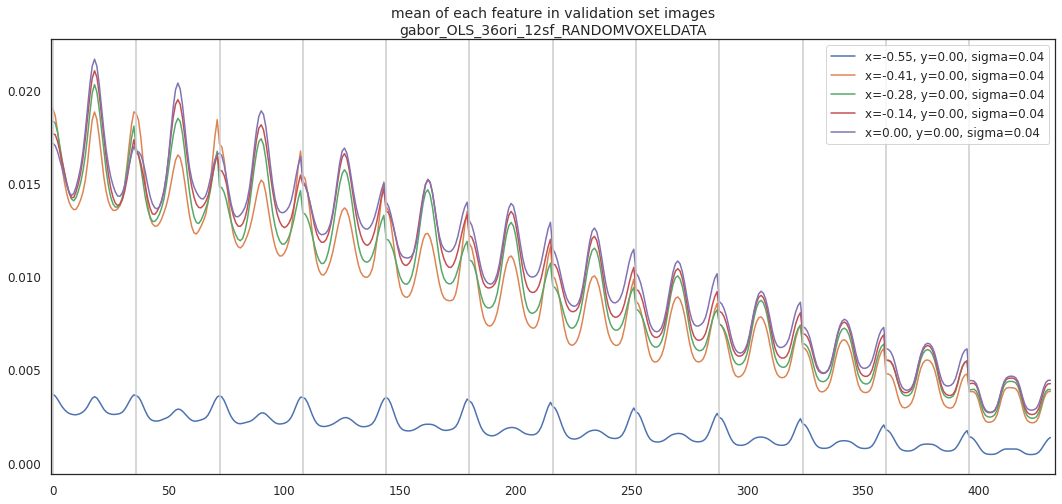

In [106]:
xvals = np.linspace(-0.55, 0, 5)
yvals = 0*np.ones(np.shape(xvals))
sigmavals = 0.04*np.ones(np.shape(xvals))

mm2use = [np.argmin(np.sum(np.abs(models-[xvals[mm], yvals[mm],sigmavals[mm]]), axis=1)) for mm in range(len(xvals))]

plt.figure(figsize=(18,8))
for mm in mm2use:
    plt.plot(np.mean(features_each_model_val[:,:,mm], axis=0))
    
plt.legend(['x=%.2f, y=%.2f, sigma=%.2f'%(xvals[mm], yvals[mm], sigmavals[mm]) for mm in range(len(xvals))])
for sf in range(n_sf):
    plt.axvline(sf*n_ori, color=[0.8, 0.8, 0.8])

plt.xlim([-1, n_ori*n_sf+1])
plt.title('mean of each feature in validation set images\n%s'%fitting_type)